# QConv2D layer

This tutorial demonstrates how to use the Quntum Convolution 2D (QConv2D) layer from Quple. The code is written using the [Tensorflow Keras Layers API](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) and the [Tensorflow Quantum Layers API](https://www.tensorflow.org/quantum/api_docs/python/tfq/layers).

## 0. Setup

In [1]:
import sys
# install modules if inside google Colab environment
if 'google.colab' in sys.modules:
    !pip install tensorflow==2.4.1
    !pip install tensorflow-quantum
    !pip install quple==0.9.0

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_quantum as tfq

from quple.utils.visualization import visualize_images
from quple.data_encoding import FirstOrderPauliZEncoding
from quple import ParameterisedCircuit

from quple.interface.tfq.layers import PQC, QConv2D

## 1. Create QConv2D layer

<img src="https://miro.medium.com/max/790/1*1VJDP6qDY9-ExTuQVEOlVg.gif" width="250" align="left"> 

- Quantum convolution uses a **quantum filter** as the basic building block. It replaces the classical filter by a Parameterised Quantum Circuit (PQC) which scan across the local regions (the **receptive field**) of an image. 

- In the classical case, an output pixel value (neuron) that are connected to a local region in the input image is computed as the dot product between the kernel weights of the classical filter and the pixel values in the local region. 

- In the quantum case, a quantum filter transforms the pixel values in the local region into the quantum states of its data circuit via a suitable feature map, hence projecting the data into a higher dimensional quantum (Hilbert) space. The quantum states are then propagated to the model circuit of the quantum filter which undergoes a sequence parameterised gate operations and outputs the expectation value of a given measurement operator. 

- The `QConv2D` layer inherits from the `PQC` layer which requires `data_circuit`, `model_circuit` and `operators` as inputs. The implementation of the `QConv2D` is similar to the `tf.keras.layers.Conv2D` layer, borrowing common concepts in traditional convolution such as `filters`, `kernel_size`, `strides` and `padding`. 

- Note that the `kernel_size` of a quantum filter does not refer to the number of trainable weights in the quantum filter but instead to the dimensions of the receptive field passed to the data circuit.

For demonstration purpose, we will use a 2x2 quantum filter in terms of a 4 qubit PQC

### data circuit for 2x2 quantum filter

A simple `FirstOrderPauliZEncoding` circuit is used as the data encoding circuit for the 2x2 quantum filter

In [2]:
data_circuit_2x2 = FirstOrderPauliZEncoding(feature_dimension=4, copies=2, parameter_scale=1)
data_circuit_2x2

(0, 0): ───H───Rz(pi*<x_0/pi>)───H───Rz(pi*<x_0/pi>)───

(0, 1): ───H───Rz(pi*<x_1/pi>)───H───Rz(pi*<x_1/pi>)───

(0, 2): ───H───Rz(pi*<x_2/pi>)───H───Rz(pi*<x_2/pi>)───

(0, 3): ───H───Rz(pi*<x_3/pi>)───H───Rz(pi*<x_3/pi>)───

### kernel circuit for 2x2 quantum filter

The kernel circuit used here is also known as the **EfficientSU2** circuit 

In [3]:
kernel_circuit_2x2 = ParameterisedCircuit(n_qubit=4, copies=2, 
                                      rotation_blocks=["RY", "RZ"],
                                      entanglement_blocks=["CX"],
                                      entangle_strategy="alternate_linear")
kernel_circuit_2x2

(0, 0): ───Ry(θ_0)───Rz(θ_4)───@───Ry(θ_8)───Rz(θ_12)──────────────@───────
                               │                                   │
(0, 1): ───Ry(θ_1)───Rz(θ_5)───X───@─────────Ry(θ_9)────Rz(θ_13)───X───@───
                                   │                                   │
(0, 2): ───Ry(θ_2)───Rz(θ_6)───@───X─────────Ry(θ_10)───Rz(θ_14)───@───X───
                               │                                   │
(0, 3): ───Ry(θ_3)───Rz(θ_7)───X─────────────Ry(θ_11)───Rz(θ_15)───X───────

In [4]:
# measure the last qubit
readout_2x2 = kernel_circuit_2x2.get_gate_operation("Z", kernel_circuit_2x2.qubits[-1])
readout_2x2

[cirq.Z(cirq.GridQubit(0, 3))]

In [5]:
# create a QConv2D layer
qconv2d = QConv2D(kernel_circuit_2x2, data_circuit_2x2, readout_2x2,
                  kernel_size=(2, 2), filters=2, strides=(1, 1), padding="same",
                  seed=2021)

## 2. Validation of the QConv2D Layer

In this section, we will verify that the implementation of the QConv2D model is consistent with classical convolution

We shall begin with some random 3x3 images

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

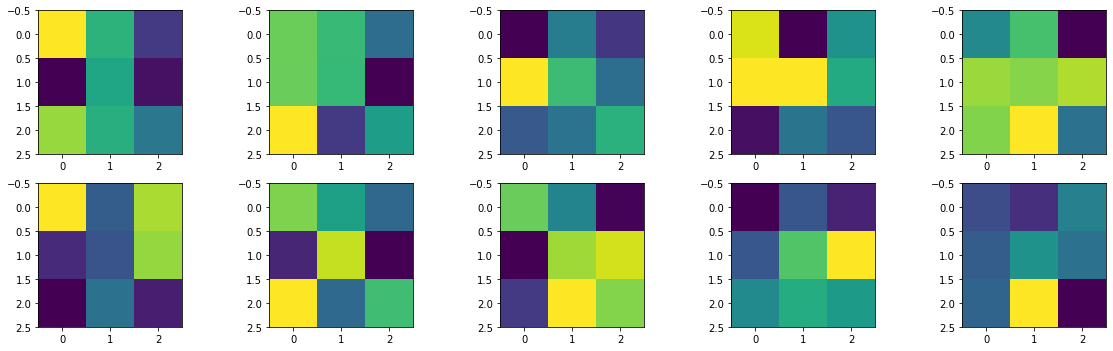

In [6]:
# ensure reproducible result
np.random.seed(2021)
sample_size = 10
x = np.random.normal(size=(sample_size, 3, 3))
visualize_images(x, columns=5)

In [7]:
# obtained the convoluted output
output = qconv2d(x).numpy()
output.shape

(10, 3, 3, 2)

Let's take a look at the output of the above simple quantum convolution

Convolution output from first filter:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

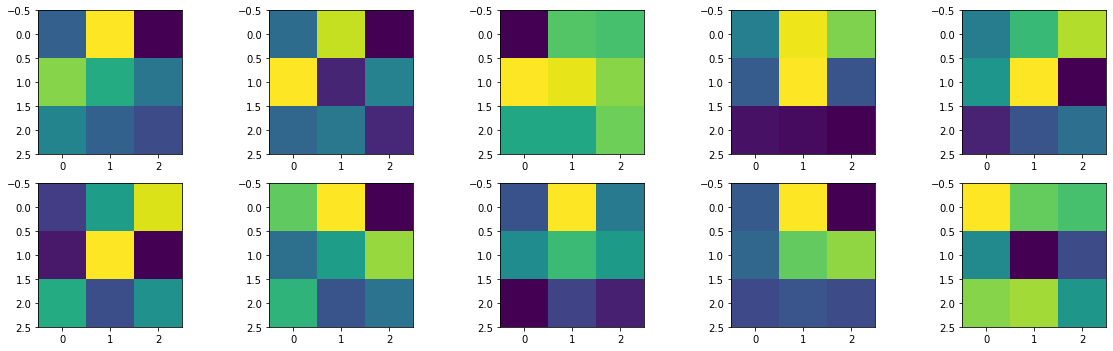

In [8]:
reshaped_output_1 = np.reshape(output[:,:,:,0], (sample_size, 3, 3))
print("Convolution output from first filter:")
visualize_images(reshaped_output_1, columns=5)

Convolution output from second filter:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

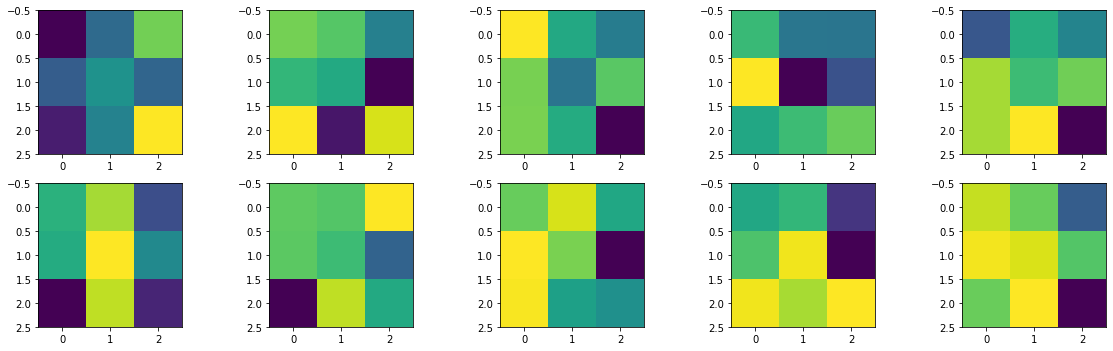

In [9]:
reshaped_output_2 = np.reshape(output[:,:,:,1], (sample_size, 3, 3))
print("Convolution output from second filter:")
visualize_images(reshaped_output_2, columns=5)

The trainable weights of the `QConv2D` layer has the shape (filters, input_channels, circuit_params)

In [10]:
weights = qconv2d.kernel
print("=================================================")
print("Kernel weights shape:")
print(weights.shape)
print("=================================================")
print("Kernel weights for first filter:")
print(weights[0, 0, :])
print("=================================================")
print("Kernel weights for second filter:")
print(weights[1, 0, :])
print("=================================================")

Kernel weights shape:
(2, 1, 16)
Kernel weights for first filter:
tf.Tensor(
[0.03559315 5.7009115  1.0772028  4.297093   6.010479   5.235625
 2.9352243  4.9933195  3.6981454  5.297507   3.907697   2.5383832
 2.9044323  3.9199426  5.579139   3.9190686 ], shape=(16,), dtype=float32)
Kernel weights for second filter:
tf.Tensor(
[4.4562674e+00 5.4074174e-01 3.1140223e+00 4.9358603e-01 1.4023731e+00
 4.7630778e-01 5.8784399e+00 3.6493928e+00 4.3248701e+00 6.0587411e+00
 3.4179924e+00 5.9370828e+00 5.0049121e-03 4.7158751e-01 3.0801444e+00
 5.3433084e+00], shape=(16,), dtype=float32)


### Extract data patches from input

To validate, we first create the data patches that are passed to the data circuit of the quantum filter

In [11]:
# change input order to (batchsize, planes, rows, cols, depths)
x_reshaped = tf.reshape(x, shape=(sample_size, 1, 3, 3, 1))
x_patches = tf.extract_volume_patches(x_reshaped, 
            ksizes=(1, 1, 2, 2, 1), strides=(1, 1, 1, 1, 1), padding="SAME")

In [12]:
print("=================================================")
print("Input 0:")
print(x[0, :, :])
print("=================================================")
print("Data patches:")
print(x_patches[0, 0, :, :, :])
print("=================================================")

Input 0:
[[ 1.48860905  0.67601087 -0.41845137]
 [-0.80652081  0.55587583 -0.70550429]
 [ 1.13085826  0.64500184  0.10641374]]
Data patches:
tf.Tensor(
[[[ 1.48860905  0.67601087 -0.80652081  0.55587583]
  [ 0.67601087 -0.41845137  0.55587583 -0.70550429]
  [-0.41845137  0.         -0.70550429  0.        ]]

 [[-0.80652081  0.55587583  1.13085826  0.64500184]
  [ 0.55587583 -0.70550429  0.64500184  0.10641374]
  [-0.70550429  0.          0.10641374  0.        ]]

 [[ 1.13085826  0.64500184  0.          0.        ]
  [ 0.64500184  0.10641374  0.          0.        ]
  [ 0.10641374  0.          0.          0.        ]]], shape=(3, 3, 4), dtype=float64)


Notice that the first data patch is the top left 2x2 region of the input sample

The 0's in the data patches come from the padding

### Manual parameter resolving

To validate the output from `QConv2D` layer, we will manually resolve the parameter values in the data and kernel circuits

In [13]:
# flatten the data patches
reshaped_patches = tf.reshape(x_patches, shape=(sample_size * 3 * 3, 4))
resolved_data_circuits = data_circuit_2x2.resolve_parameters(reshaped_patches.numpy())

In [14]:
# first data patch from first sample
resolved_data_circuits[0]

(0, 0): ───H───Rz(0.474π)────H───Rz(0.474π)────

(0, 1): ───H───Rz(0.215π)────H───Rz(0.215π)────

(0, 2): ───H───Rz(-0.257π)───H───Rz(-0.257π)───

(0, 3): ───H───Rz(0.177π)────H───Rz(0.177π)────

In [15]:
weights.numpy().shape

(2, 1, 16)

In [16]:
# first filter
resolved_kernel_circuit_1 = kernel_circuit_2x2.resolve_parameters(weights[0, 0, :].numpy())
resolved_kernel_circuit_1

(0, 0): ───Ry(0.011π)───Rz(1.91π)────@───Ry(1.18π)───Rz(0.925π)───────────────@───────
                                     │                                        │
(0, 1): ───Ry(1.81π)────Rz(1.67π)────X───@───────────Ry(1.69π)────Rz(1.25π)───X───@───
                                         │                                        │
(0, 2): ───Ry(0.343π)───Rz(0.934π)───@───X───────────Ry(1.24π)────Rz(1.78π)───@───X───
                                     │                                        │
(0, 3): ───Ry(1.37π)────Rz(1.59π)────X───────────────Ry(0.808π)───Rz(1.25π)───X───────

In [17]:
# second filter
resolved_kernel_circuit_2 = kernel_circuit_2x2.resolve_parameters(weights[1, 0, :].numpy())
resolved_kernel_circuit_2

(0, 0): ───Ry(1.42π)────Rz(0.446π)───@───Ry(1.38π)───Rz(0.002π)───────────────@───────
                                     │                                        │
(0, 1): ───Ry(0.172π)───Rz(0.152π)───X───@───────────Ry(1.93π)────Rz(0.15π)───X───@───
                                         │                                        │
(0, 2): ───Ry(0.991π)───Rz(1.87π)────@───X───────────Ry(1.09π)────Rz(0.98π)───@───X───
                                     │                                        │
(0, 3): ───Ry(0.157π)───Rz(1.16π)────X───────────────Ry(1.89π)────Rz(1.7π)────X───────

In [18]:
combined_circuits_1 = []
combined_circuits_2 = []
for cq in resolved_data_circuits:
    combined_circuit_1 = ParameterisedCircuit.from_cirq(cq + resolved_kernel_circuit_1)
    combined_circuit_2 = ParameterisedCircuit.from_cirq(cq + resolved_kernel_circuit_2)
    combined_circuits_1.append(combined_circuit_1)
    combined_circuits_2.append(combined_circuit_2)

In [19]:
combined_circuits_1[0]

(0, 0): ───H───Rz(0.474π)────H───Rz(0.474π)────Ry(0.011π)───Rz(1.91π)────@───Ry(1.18π)───Rz(0.925π)───────────────@───────
                                                                         │                                        │
(0, 1): ───H───Rz(0.215π)────H───Rz(0.215π)────Ry(1.81π)────Rz(1.67π)────X───@───────────Ry(1.69π)────Rz(1.25π)───X───@───
                                                                             │                                        │
(0, 2): ───H───Rz(-0.257π)───H───Rz(-0.257π)───Ry(0.343π)───Rz(0.934π)───@───X───────────Ry(1.24π)────Rz(1.78π)───@───X───
                                                                         │                                        │
(0, 3): ───H───Rz(0.177π)────H───Rz(0.177π)────Ry(1.37π)────Rz(1.59π)────X───────────────Ry(0.808π)───Rz(1.25π)───X───────

In [20]:
combined_circuits_2[0]

(0, 0): ───H───Rz(0.474π)────H───Rz(0.474π)────Ry(1.42π)────Rz(0.446π)───@───Ry(1.38π)───Rz(0.002π)───────────────@───────
                                                                         │                                        │
(0, 1): ───H───Rz(0.215π)────H───Rz(0.215π)────Ry(0.172π)───Rz(0.152π)───X───@───────────Ry(1.93π)────Rz(0.15π)───X───@───
                                                                             │                                        │
(0, 2): ───H───Rz(-0.257π)───H───Rz(-0.257π)───Ry(0.991π)───Rz(1.87π)────@───X───────────Ry(1.09π)────Rz(0.98π)───@───X───
                                                                         │                                        │
(0, 3): ───H───Rz(0.177π)────H───Rz(0.177π)────Ry(0.157π)───Rz(1.16π)────X───────────────Ry(1.89π)────Rz(1.7π)────X───────

Let's check the result by simulating the resolved circuit for the quantum filter(s)

In [21]:
output_from_resolved_circuits_1 = []
output_from_resolved_circuits_2 = []
for cq1, cq2 in zip(combined_circuits_1, combined_circuits_2):
    output_1 = cq1.get_expectation(operators=readout_2x2, repetitions=1000000)[0, 0]
    output_2 = cq2.get_expectation(operators=readout_2x2, repetitions=1000000)[0, 0]
    output_from_resolved_circuits_1.append(output_1)
    output_from_resolved_circuits_2.append(output_2)
output_from_resolved_circuits_1 = np.reshape(output_from_resolved_circuits_1, (sample_size, 3, 3))
output_from_resolved_circuits_2 = np.reshape(output_from_resolved_circuits_2, (sample_size, 3, 3))

Validation output from first filter:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

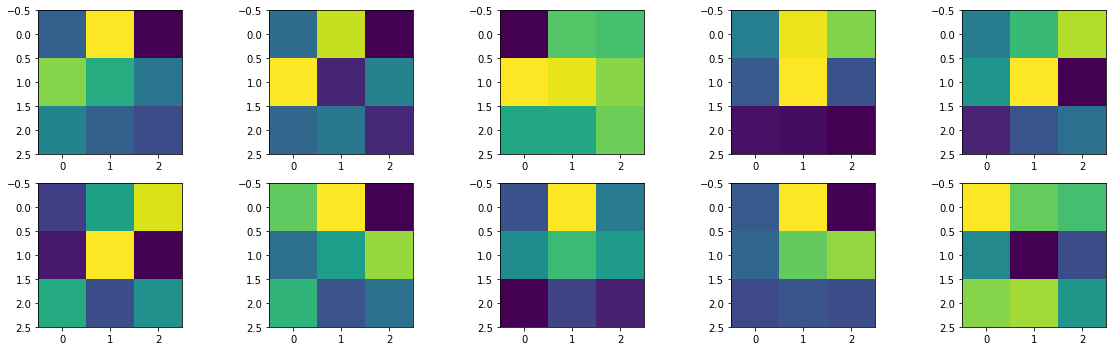

In [22]:
print("Validation output from first filter:")
visualize_images(output_from_resolved_circuits_1, columns=5)

Validation output from second filter:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

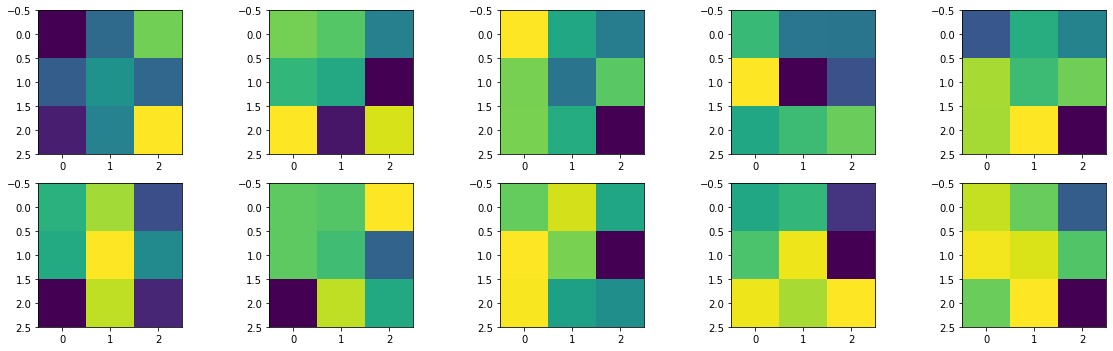

In [23]:
print("Validation output from second filter:")
visualize_images(output_from_resolved_circuits_2, columns=5)

### Comparing results

Here we compare the results obtained from
1. QConv2D
2. Manually resolving quantul filter circuit and evaluate the expection value of operators

In [24]:
# for first filter
output_from_resolved_circuits_1 - reshaped_output_1

array([[[-1.5299022e-04,  9.8049641e-04, -1.0008179e-03],
        [-4.9996376e-04,  8.3410740e-04, -8.8033080e-04],
        [ 9.6946955e-04,  3.8565695e-04, -1.5753508e-04]],

       [[ 1.0838509e-03, -3.2949448e-04, -1.2893155e-03],
        [ 6.7412853e-04, -9.0897083e-07,  3.5485625e-04],
        [-5.1921606e-04, -3.6156178e-04, -5.9112906e-05]],

       [[ 1.0201335e-04,  4.6968460e-05, -2.1538138e-04],
        [-3.8778782e-04, -3.3974648e-05, -1.2436509e-04],
        [-1.5853345e-04,  6.9226325e-04,  5.6475401e-04]],

       [[ 5.6231022e-04, -1.8405318e-03,  5.0875545e-04],
        [-6.1070919e-04, -1.8662214e-04, -1.6538501e-03],
        [ 2.2648275e-04,  1.6269982e-03,  4.0277839e-05]],

       [[ 1.9466877e-04, -1.5837550e-03, -5.9580803e-04],
        [-1.1562705e-03, -2.4271011e-04,  8.5761398e-04],
        [ 1.6254187e-03,  9.9053979e-04,  1.8909574e-04]],

       [[ 8.8806450e-04,  2.2664070e-03, -1.5537143e-03],
        [-2.0178705e-03, -1.5974045e-04, -1.3592094e-04],
    

In [25]:
# for second filter
output_from_resolved_circuits_2 - reshaped_output_2

array([[[-5.7804585e-04, -1.5999377e-04,  1.5589595e-04],
        [ 1.0895729e-03,  2.3336634e-03,  6.7928433e-04],
        [ 1.8140376e-03, -3.9190054e-05,  1.4349818e-05]],

       [[ 1.3648197e-03,  1.1536125e-03,  1.3526380e-03],
        [ 3.5551935e-04, -1.1617243e-03,  6.7287683e-04],
        [ 7.5891614e-05,  1.0305643e-03,  2.9720366e-04]],

       [[ 6.9141388e-06, -1.5332550e-04,  1.5339851e-03],
        [ 1.7271638e-03, -1.1091679e-03,  1.5018508e-03],
        [ 4.3013692e-04,  1.3006842e-03,  1.7219782e-04]],

       [[-2.0830035e-03, -5.2526593e-04, -7.2412938e-04],
        [-9.1007352e-04,  7.1793795e-05, -8.3893538e-04],
        [ 4.6295673e-04,  6.3160062e-04,  9.5413625e-04]],

       [[ 8.6668134e-04,  8.3248317e-04, -9.9337101e-04],
        [ 6.0606748e-04, -2.0386279e-04, -1.2503937e-04],
        [-6.3583627e-04, -2.5697052e-04,  8.2671642e-04]],

       [[ 5.4465234e-04,  1.0800734e-04,  1.2296140e-03],
        [-2.4126470e-04,  1.5266985e-03,  2.7483702e-04],
    

The major reason for the small difference is due to simulation using sampling for the resolved circuit method versus the analytic simulation for the tfq default simulator

## 3. Create a simple CNN model from QConv2D

To demonstrate, we create two classes of easily distinguishable 4x4 images. 

- A total of 1000 samples are used, half for each class. 
- 500 samples are used for training, 250 for validation, 250 for testing

In [26]:
# for reproducibility
np.random.seed(2021)
sample_size = 500
x_class_1 = np.random.normal(1, 0.1, size=(sample_size, 4, 4))
x_class_2 = np.random.normal(1, 0.1, size=(sample_size, 4, 4))
mesh_1 = np.array([[0, 1, 1, 0],
                   [1, 0, 0, 1],
                   [1, 0, 0, 1],
                   [0, 1, 1, 0]])
mesh_2 = np.array([[1, 0, 0, 1],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0],
                   [1, 0, 0, 1]])
x_class_1 = x_class_1 - mesh_1
x_class_2 = x_class_2 - mesh_2
from quple.utils.data_preparation import rescale_data
x_class_1 = rescale_data(x_class_1, val_range=(-1, 1))
x_class_2 = rescale_data(x_class_2, val_range=(-1, 1))

Class 1 image:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

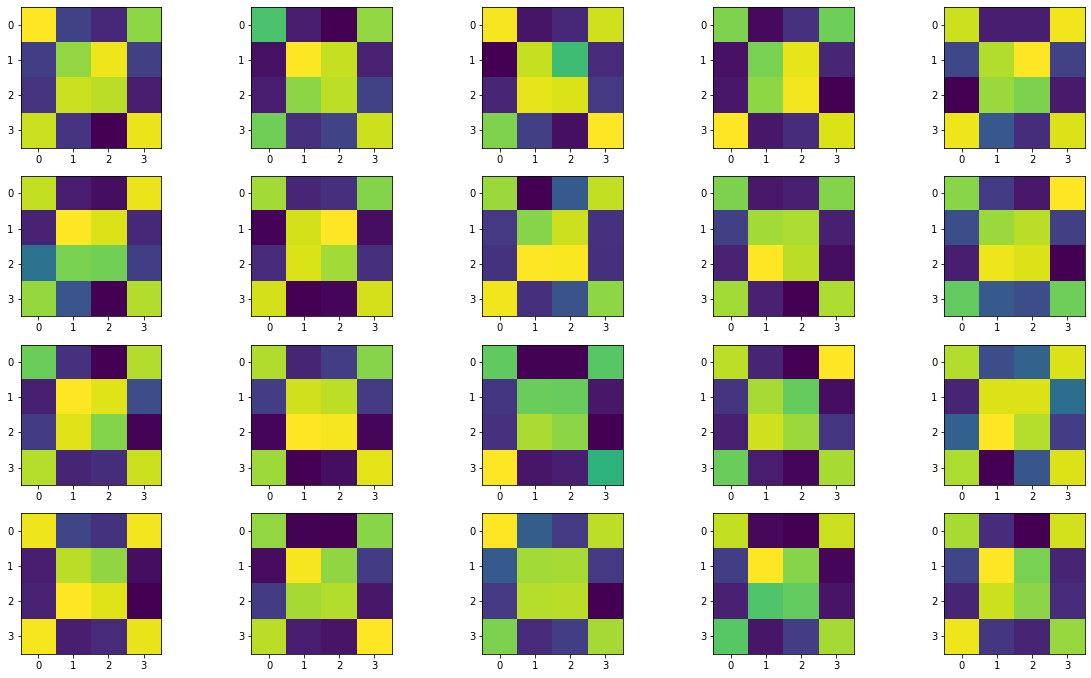

In [27]:
print("Class 1 image:")
visualize_images(x_class_1[:20], columns=5)

Class 2 image:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

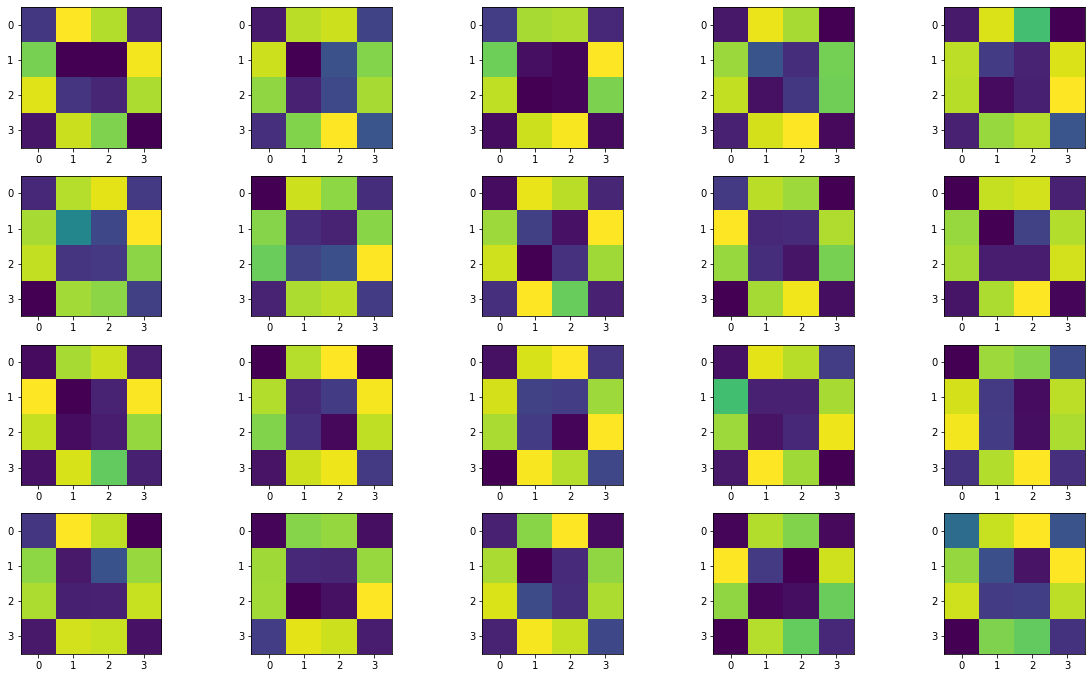

In [28]:
print("Class 2 image:")
visualize_images(x_class_2[:20], columns=5)

Create training, validation and test datasets

In [29]:
x = np.concatenate((x_class_1, x_class_2))
y = np.concatenate((np.zeros(sample_size), np.ones(sample_size)))
from sklearn.utils import shuffle
x, y = shuffle(x, y, random_state=2021)
x_train = x[:500]
y_train = y[:500]
x_val = x[500:750]
y_val = y[500:750]
x_test = x[750:]
y_test = y[750:]

Train image:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

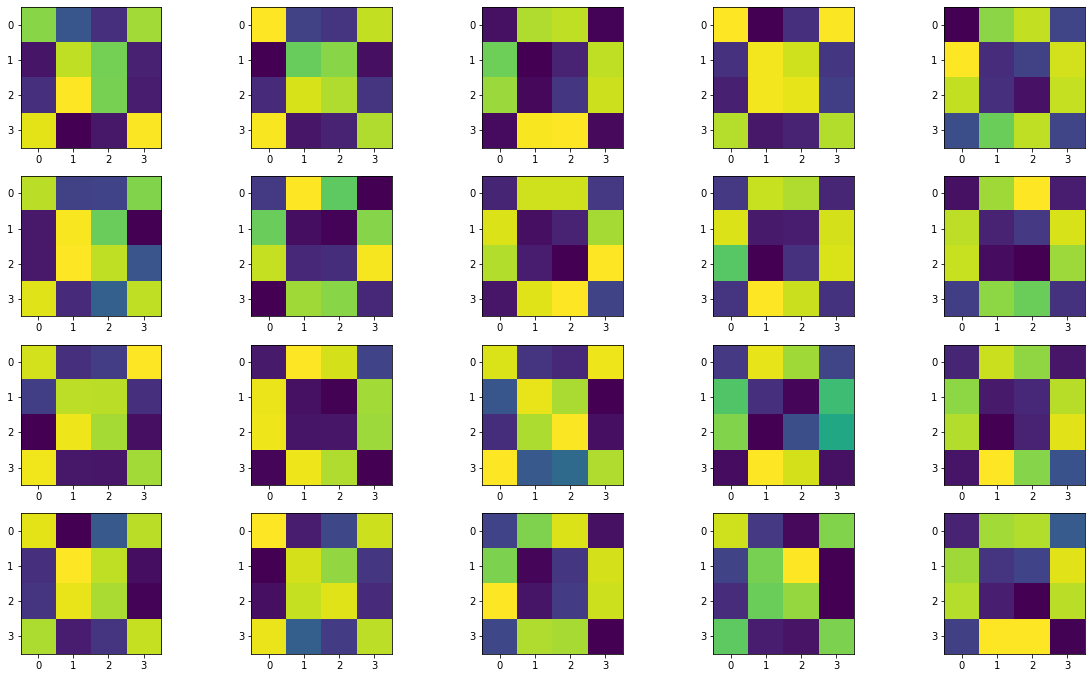

In [30]:
print("Train image:")
visualize_images(x_train[:20], columns=5)

Now create a QCNN model with the following architecture:
1. one Conv2D layer with 2x2 kernel, 1 filter and 1x1 stride -> output 8x8 image
2. one Conv2D layer with 2x2 kernel, 1 filter and 2x2 stride -> output 4x4 image
3. one PQC layer with 4 qubits -> output classification score

In [31]:
data_circuit_2x2 = FirstOrderPauliZEncoding(feature_dimension=4, copies=2, parameter_scale=1)
data_circuit_2x2

(0, 0): ───H───Rz(pi*<x_0/pi>)───H───Rz(pi*<x_0/pi>)───

(0, 1): ───H───Rz(pi*<x_1/pi>)───H───Rz(pi*<x_1/pi>)───

(0, 2): ───H───Rz(pi*<x_2/pi>)───H───Rz(pi*<x_2/pi>)───

(0, 3): ───H───Rz(pi*<x_3/pi>)───H───Rz(pi*<x_3/pi>)───

In [32]:
kernel_circuit_2x2 = ParameterisedCircuit(n_qubit=4, copies=2, 
                                      rotation_blocks=["RY", "RZ"],
                                      entanglement_blocks=["CX"],
                                      entangle_strategy="alternate_linear",
                                      final_rotation_layer=True)
kernel_circuit_2x2

(0, 0): ───Ry(θ_0)───Rz(θ_4)───@───Ry(θ_8)───Rz(θ_12)──────────────@───Ry(θ_16)───Rz(θ_20)──────────────
                               │                                   │
(0, 1): ───Ry(θ_1)───Rz(θ_5)───X───@─────────Ry(θ_9)────Rz(θ_13)───X───@──────────Ry(θ_17)───Rz(θ_21)───
                                   │                                   │
(0, 2): ───Ry(θ_2)───Rz(θ_6)───@───X─────────Ry(θ_10)───Rz(θ_14)───@───X──────────Ry(θ_18)───Rz(θ_22)───
                               │                                   │
(0, 3): ───Ry(θ_3)───Rz(θ_7)───X─────────────Ry(θ_11)───Rz(θ_15)───X──────────────Ry(θ_19)───Rz(θ_23)───

In [33]:
# measure the last qubit
readout_2x2 = kernel_circuit_2x2.get_gate_operation("Z", kernel_circuit_2x2.qubits[-1])
readout_2x2

[cirq.Z(cirq.GridQubit(0, 3))]

In [34]:
PQC_data_circuit = FirstOrderPauliZEncoding(feature_dimension=4, copies=2, parameter_scale=1)
PQC_data_circuit

(0, 0): ───H───Rz(pi*<x_0/pi>)───H───Rz(pi*<x_0/pi>)───

(0, 1): ───H───Rz(pi*<x_1/pi>)───H───Rz(pi*<x_1/pi>)───

(0, 2): ───H───Rz(pi*<x_2/pi>)───H───Rz(pi*<x_2/pi>)───

(0, 3): ───H───Rz(pi*<x_3/pi>)───H───Rz(pi*<x_3/pi>)───

In [35]:
PQC_model_circuit = ParameterisedCircuit(n_qubit=4, copies=3, 
                                      rotation_blocks=["RY", "RZ"],
                                      entanglement_blocks=["ZZ", "XX"],
                                      entangle_strategy="alternate_linear")
PQC_model_circuit

(0, 0): ───Ry(θ_0)───Rz(θ_4)───ZZ─────────────────────XX──────────Ry(θ_14)────Rz(θ_18)──────────────ZZ──────────────────────XX──────────Ry(θ_28)────Rz(θ_32)──────────────ZZ──────────────────────XX──────────────────────
                               │                      │                                             │                       │                                             │                       │
(0, 1): ───Ry(θ_1)───Rz(θ_5)───ZZ^(θ_8)───ZZ──────────XX^(θ_11)───XX──────────Ry(θ_15)───Rz(θ_19)───ZZ^(θ_22)───ZZ──────────XX^(θ_25)───XX──────────Ry(θ_29)───Rz(θ_33)───ZZ^(θ_36)───ZZ──────────XX^(θ_39)───XX──────────
                                          │                       │                                             │                       │                                             │                       │
(0, 2): ───Ry(θ_2)───Rz(θ_6)───ZZ─────────ZZ^(θ_10)───XX──────────XX^(θ_13)───Ry(θ_16)───Rz(θ_20)───ZZ──────────ZZ^(θ_24)───XX──────────XX^(θ_27)───Ry(θ_30)───Rz(θ_34)───ZZ──────────ZZ^(θ_38)───XX──────────XX^(θ_41)───
                               │                      │                                             │                       │                                             │                       │
(0, 3): ───Ry(θ_3)───Rz(θ_7)───ZZ^(θ_9)───────────────XX^(θ_12)───────────────Ry(θ_17)───Rz(θ_21)───ZZ^(θ_23)───────────────XX^(θ_26)───────────────Ry(θ_31)───Rz(θ_35)───ZZ^(θ_37)───────────────XX^(θ_40)───────────────

In [36]:
# measure the last qubit
PQC_readout = PQC_model_circuit.get_gate_operation("Z", PQC_model_circuit.qubits[-1])
PQC_readout

[cirq.Z(cirq.GridQubit(0, 3))]

In [46]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(4, 4), dtype=tf.float32))
model.add(QConv2D(kernel_circuit_2x2, data_circuit_2x2, readout_2x2, kernel_size=(2, 2), 
                    filters=1, strides=(1, 1), padding="same", seed=2021))
model.add(QConv2D(kernel_circuit_2x2, data_circuit_2x2, readout_2x2, kernel_size=(2, 2), 
                    filters=1, strides=(2, 2), padding="same", seed=2022))
model.add(tf.keras.layers.Flatten())
model.add(PQC(PQC_model_circuit, PQC_data_circuit, PQC_readout, seed=2023))

In [39]:
tf.random.set_seed(2021)
model.compile(optimizer="adam", loss="mse", metrics=['binary_accuracy'])

No train the model. 

In the first few epochs, the accuracy is not going up. This is probably due to the sharp boundary of the images. 

At around 8 epochs, the CNN classifier reached perfect accuracy.

In [40]:
model.fit(x_train, y_train, batch_size=16, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
32/32 [==============================] - 9s 247ms/step - loss: 1.7425 - binary_accuracy: 0.4768 - val_loss: 1.2240 - val_binary_accuracy: 0.5520
Epoch 2/15
32/32 [==============================] - 7s 214ms/step - loss: 1.3332 - binary_accuracy: 0.4342 - val_loss: 0.7477 - val_binary_accuracy: 0.5520
Epoch 3/15
32/32 [==============================] - 7s 214ms/step - loss: 0.7535 - binary_accuracy: 0.4742 - val_loss: 0.4181 - val_binary_accuracy: 0.5520
Epoch 4/15
32/32 [==============================] - 7s 216ms/step - loss: 0.4724 - binary_accuracy: 0.4387 - val_loss: 0.2839 - val_binary_accuracy: 0.5520
Epoch 5/15
32/32 [==============================] - 7s 213ms/step - loss: 0.3044 - binary_accuracy: 0.4736 - val_loss: 0.2392 - val_binary_accuracy: 0.5520
Epoch 6/15
32/32 [==============================] - 7s 214ms/step - loss: 0.2516 - binary_accuracy: 0.4798 - val_loss: 0.2208 - val_binary_accuracy: 0.5520
Epoch 7/15
32/32 [==============================] - 7s 214ms/ste

In [41]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 2s 187ms/step - loss: 0.0553 - binary_accuracy: 1.0000
test loss, test acc: [0.055333204567432404, 1.0]


In [42]:
y_pred = model.predict(x_test).flatten()

In [43]:
pred_labels = np.where(y_pred < 0.5, 0., 1.)

In [44]:
pred_labels[:100]

array([0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.])

In [45]:
y_test[:100]

array([0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.])

Let's find out what each Conv2D layer does

In [64]:
conv2d_layer1_output = model.layers[0](x_test)
conv2d_layer2_output = model.layers[1](conv2d_layer1_output)

Ouput from first QConv2D layer:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

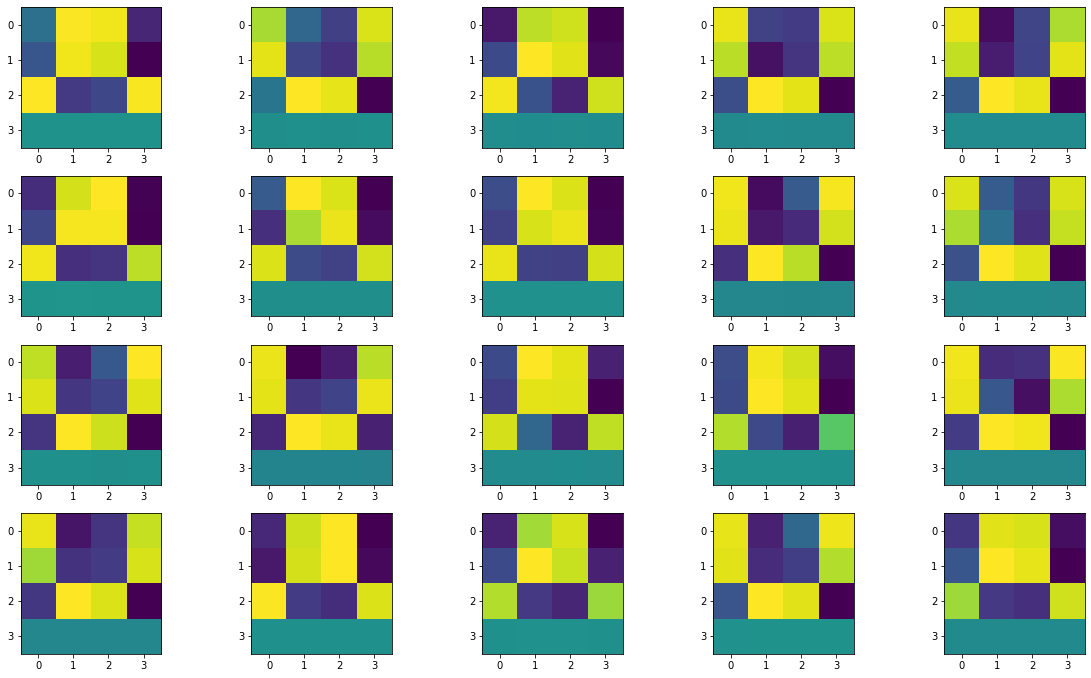

In [65]:
print("Ouput from first QConv2D layer:")
visualize_images(conv2d_layer1_output[:20], columns=5)

Ouput from second QConv2D layer:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

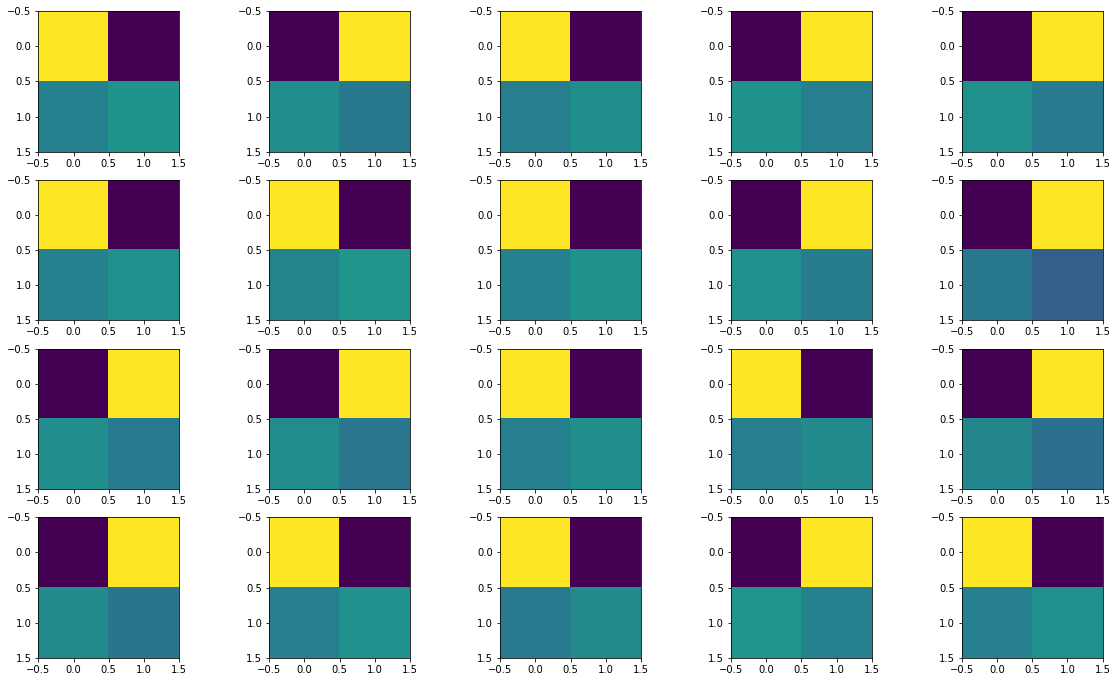

In [66]:
print("Ouput from second QConv2D layer:")
visualize_images(conv2d_layer2_output[:20], columns=5)

Now try another architecture:
1. one Conv2D layer with 2x2 kernel, 4 filter and 1x1 stride -> output 8x8 image with depth 4
2. one Conv2D layer with 2x2 kernel, 1 filter and 2x2 stride -> output 4x4 image with depth 1
3. one PQC layer with 4 qubits -> output classification score

In [50]:
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Input(shape=(4, 4), dtype=tf.float32))
model_2.add(QConv2D(kernel_circuit_2x2, data_circuit_2x2, readout_2x2, kernel_size=(2, 2), 
                    filters=4, strides=(1, 1), padding="same", seed=2021))
model_2.add(QConv2D(kernel_circuit_2x2, data_circuit_2x2, readout_2x2, kernel_size=(2, 2), 
                    filters=1, strides=(2, 2), padding="same", seed=2022))
model_2.add(tf.keras.layers.Flatten())
model_2.add(PQC(PQC_model_circuit, PQC_data_circuit, PQC_readout, seed=2023))

In [51]:
tf.random.set_seed(2021)
model_2.compile(optimizer="adam", loss="mse", metrics=['binary_accuracy'])

Now train the model.

This time it requires around 9 epochs to reach perfect accuracy.

In [52]:
model_2.fit(x_train, y_train, batch_size=16, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
32/32 [==============================] - 20s 604ms/step - loss: 1.7291 - binary_accuracy: 0.4768 - val_loss: 1.2456 - val_binary_accuracy: 0.5520
Epoch 2/15
32/32 [==============================] - 19s 603ms/step - loss: 1.3656 - binary_accuracy: 0.4342 - val_loss: 0.7774 - val_binary_accuracy: 0.5520
Epoch 3/15
32/32 [==============================] - 19s 604ms/step - loss: 0.7869 - binary_accuracy: 0.4742 - val_loss: 0.4404 - val_binary_accuracy: 0.5520
Epoch 4/15
32/32 [==============================] - 19s 599ms/step - loss: 0.4968 - binary_accuracy: 0.4387 - val_loss: 0.2962 - val_binary_accuracy: 0.5520
Epoch 5/15
32/32 [==============================] - 19s 603ms/step - loss: 0.3172 - binary_accuracy: 0.4736 - val_loss: 0.2511 - val_binary_accuracy: 0.5520
Epoch 6/15
32/32 [==============================] - 19s 602ms/step - loss: 0.2648 - binary_accuracy: 0.4798 - val_loss: 0.2397 - val_binary_accuracy: 0.5520
Epoch 7/15
32/32 [==============================] - 19s 60

In [58]:
print("Evaluate on test data")
results = model_2.evaluate(x_test, y_test, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 5s 612ms/step - loss: 0.0997 - binary_accuracy: 1.0000
test loss, test acc: [0.09973854571580887, 1.0]


In [59]:
y_pred = model_2.predict(x_test).flatten()

In [60]:
pred_labels = np.where(y_pred < 0.5, 0., 1.)

In [61]:
pred_labels[:100]

array([0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.])

In [62]:
y_test[:100]

array([0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.])

Let's find out what each Conv2D layer does

In [67]:
conv2d_layer1_output_model2 = model_2.layers[0](x_test)
conv2d_layer2_output_model2 = model_2.layers[1](conv2d_layer1_output_model2)

In [68]:
conv2d_layer1_output_model2.shape

TensorShape([250, 4, 4, 4])

Ouput from first QConv2D layer (filter 1):


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

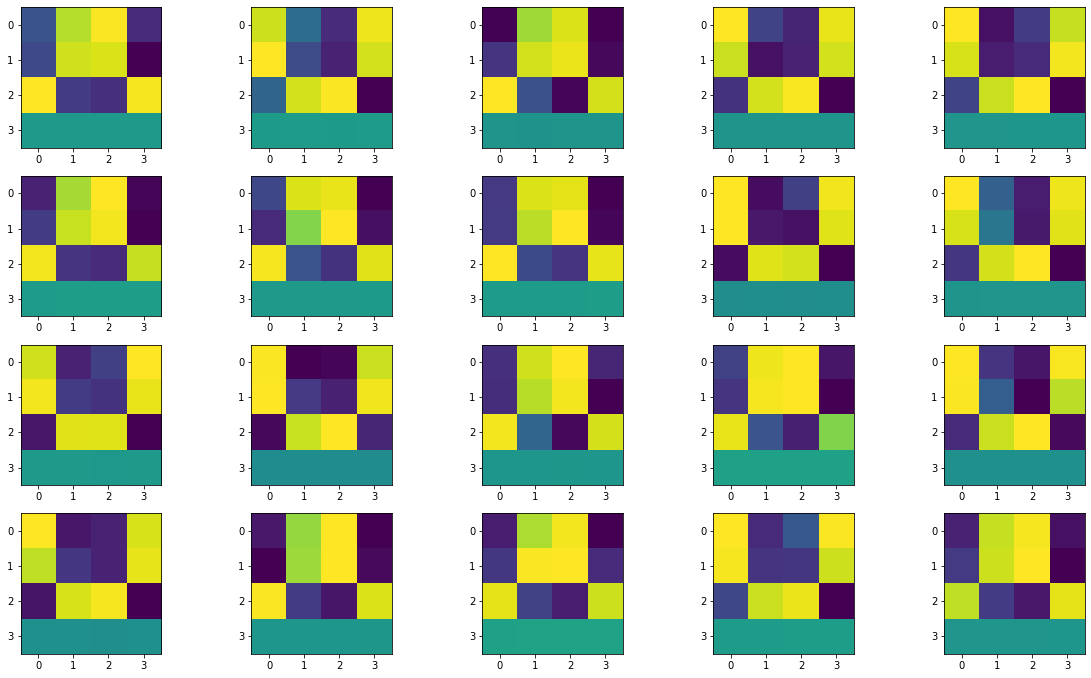

In [72]:
print("Ouput from first QConv2D layer (filter 1):")
visualize_images(conv2d_layer1_output_model2[:20, :, :, 0], columns=5)

Ouput from first QConv2D layer (filter 2):


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

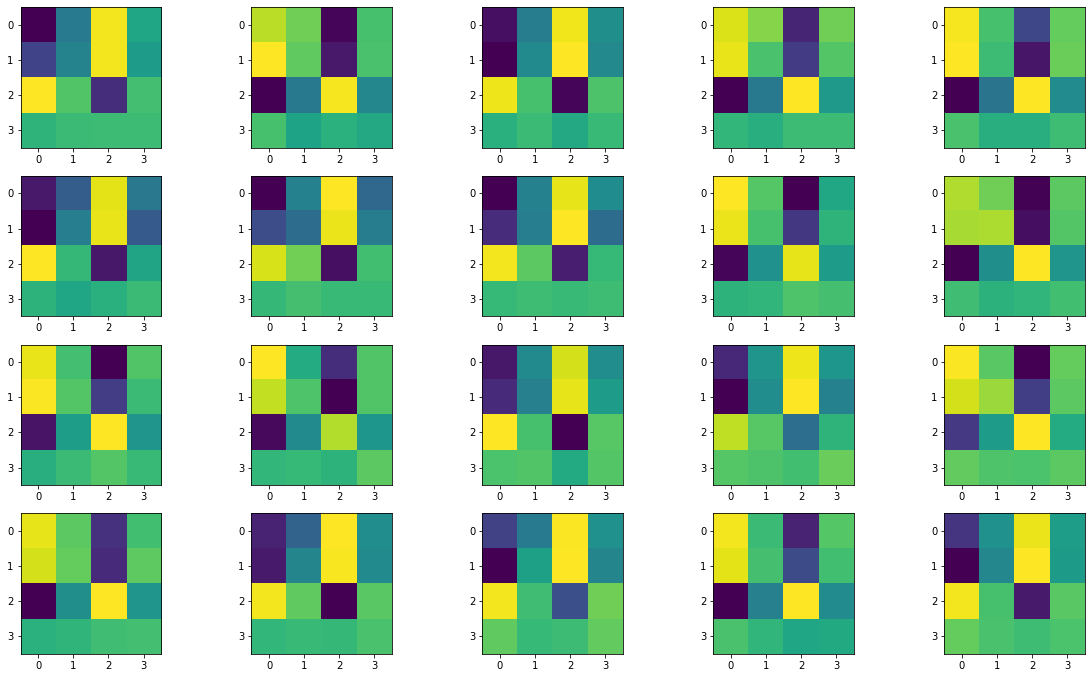

In [74]:
print("Ouput from first QConv2D layer (filter 2):")
visualize_images(conv2d_layer1_output_model2[:20, :, :, 1], columns=5)

Ouput from first QConv2D layer (filter 3):


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

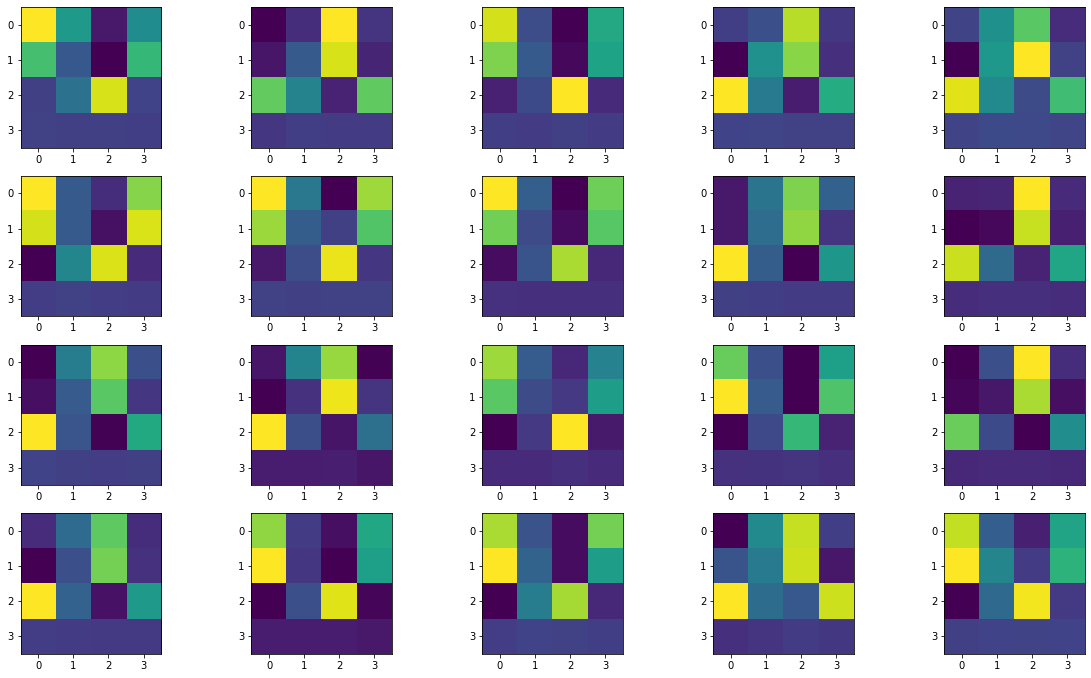

In [75]:
print("Ouput from first QConv2D layer (filter 3):")
visualize_images(conv2d_layer1_output_model2[:20, :, :, 2], columns=5)

Ouput from first QConv2D layer (filter 4):


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

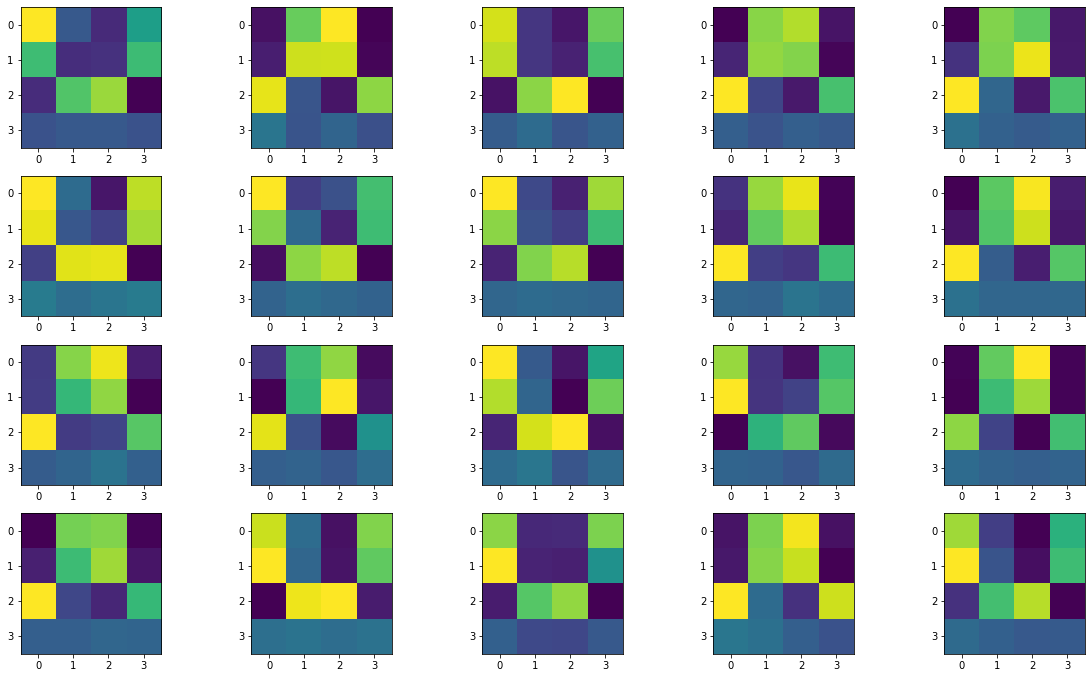

In [76]:
print("Ouput from first QConv2D layer (filter 4):")
visualize_images(conv2d_layer1_output_model2[:20, :, :, 3], columns=5)

Ouput from second QConv2D layer:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

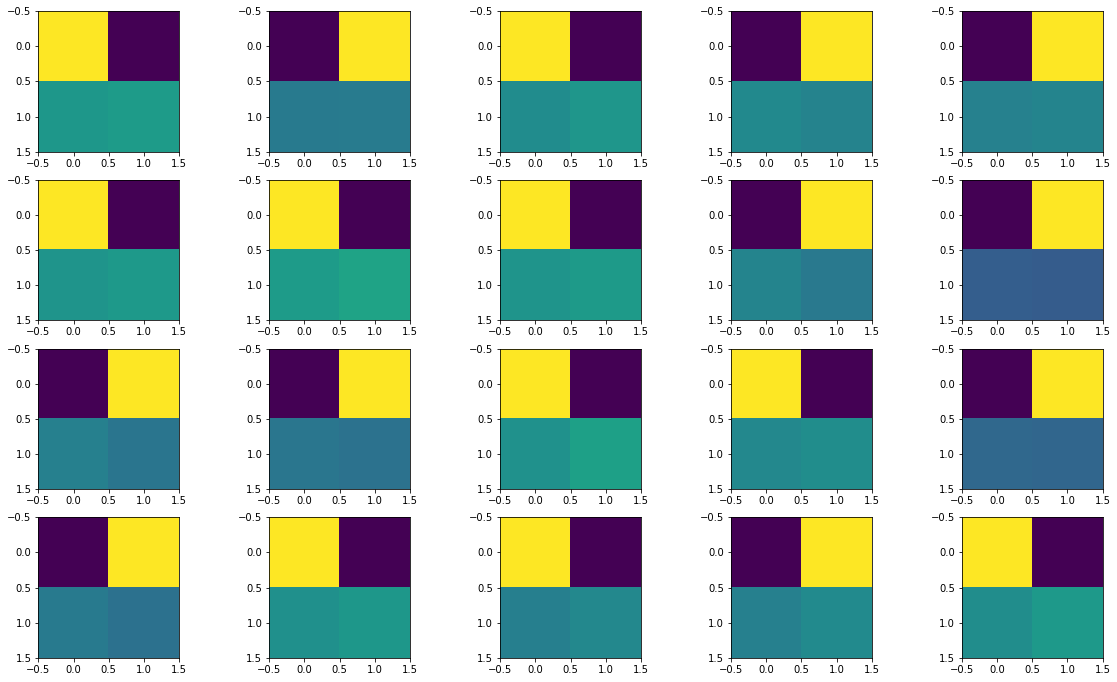

In [77]:
print("Ouput from second QConv2D layer:")
visualize_images(conv2d_layer2_output_model2[:20], columns=5)